# Udacity DAND OSM w/ MongoDB - Project 3

Please view the OSM_CaseStudySummary.pdf directly as embedded in the notebook.

The rest of the notebook containc all the code and the steps to complete the project.

(If running the code, please export the .json file and start MongoDB when noted in the notebook.)

In [1]:
from IPython.display import HTML
HTML('<iframe src=OSM_CaseStudySummary.pdf width=800 height=1200></iframe>')

## Coding Notebook ##

In [2]:
%matplotlib inline
from collections import defaultdict
import xml.etree.cElementTree as ET
from xml.etree.ElementTree import iterparse
from pprint import pprint
import re
import codecs
import json
import pandas as pd
from IPython.display import display
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from mpl_toolkits.basemap import Basemap

osmfile = 'OSM_JerseyCityHoboken.xml'

/Users/mattelisa/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Count the Elements ###

In [3]:
# Iterate through the element tree and put each tag and quantity in a dictionary
def count_tags(filename):
    tag_names = defaultdict(int)
    for (event, elem) in iterparse(filename, ['start']): 
        tag_names[elem.tag] += 1
    return dict(tag_names)

pprint(count_tags(osmfile))

{'member': 63531,
 'meta': 1,
 'nd': 644614,
 'node': 510264,
 'note': 1,
 'osm': 1,
 'relation': 525,
 'tag': 161809,
 'way': 79972}


### Iterative Cleansing of the Street Types (Street, Avenue, Road, etc) ###

In [4]:
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

In [5]:
# Helper functions taken from Udacity DAND Data Wrangling OSM Case Study
#
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "Center", "Highway", "Plaza", "Turnpike", "Walk",
            "Walkway", "Way", "East", "Hudson", "North", "South"] # The last 5 are odd, but correct

miscoded_house_numbers = ["1204", "3", "C"] # Update in a future stage

# Mapping for First Stage Clensing
mapping = { "St": "Street",
            "St.": "Street",
            "Ave" : "Avenue",
            "Rd." : "Road",
           "Blvd" : "Boulevard",
           "Ctr" : "Center",
           "Clinton" : "Clinton Street",
           "1st" : "1st Street",
           "NJ)" : ""
            }

def update_name(name, mapping):
    m = street_type_re.search(name)
    if m:
        s = name[:m.start()] + mapping[m.group()]
        print s
    return s

dict_all = audit(osmfile)
dict_map = {}
print "First Stage Street Type Mappings:"
print
for key, value in dict_all.iteritems():
    if key in mapping:
        dict_map[key] = dict_all[key]
pprint(dict_map)
        

First Stage Street Type Mappings:

{'1st': set(['1st']),
 'Ave': set(['Bergenline Ave', 'Park Ave', 'Webster Ave', 'Willow Ave']),
 'Blvd': set(['Marin Blvd']),
 'Clinton': set(['Clinton']),
 'Ctr': set(['Harborside Fin Ctr']),
 'NJ)': set(['US 1 (NJ)']),
 'St': set(['1st St',
            '2nd St',
            '3rd St',
            '4th St',
            '6th St',
            '7th St',
            '8th St',
            '9th St',
            'Adams St',
            'Bloomfield St',
            'Clinton St',
            'Court St',
            'Garden St',
            'Grand St',
            'Hudson St',
            'Jackson St',
            'Jefferson St',
            'Madison St',
            'Monroe St',
            'Newark St',
            'River St',
            'Washington St']),
 'St.': set(['Harrison St.', 'Warren St.', 'Washington St.'])}


*** The above Street types will be updated using the mapping dictionary ***

The Street types in the expected list will not be changed.

*** Next - Let's check what remains ***

In [6]:
print "Street Types Not Mapped in Stage 1"
print
dict_all = audit(osmfile)
dict_errors = {}
for key, value in dict_all.iteritems():
    if ((key in mapping) == False) and ((key in expected) == False):
        dict_errors[key] = dict_all[key]
pprint(dict_errors)


Street Types Not Mapped in Stage 1

{'1204': set(['Journal Square #1204']),
 '3': set(['16th Street # 3']),
 'C': set(['2nd Street #C', 'Avenue C'])}


***These Street types are wrong, but cannot be corrected with mapping.***

- '1204' and '3' are house numbers mis-coded in the Street Name.
- 'C' is correct when it is 'Avenue C', but it is also a house number when used in 2nd Street

*** I propose the following rules rules to *cleanse* these three elements: ***
- Using Submine Test, find the tags for: 'Journal Square #1204', '16th Street # 3', and '2nd Street #C'
- I confirmed the extra data are the *** Suite Numbers *** for these addresses 
- Manually update 'Journal Square #1204' to 'Journal Square'
- Manually update '16th Street # 3' to '16th Street'
- Manually update '2nd Street #C' to '2nd Street'
- Add 'C' to the "expected" list
- Write an updated OSM file


***Finally, re-run the previous code and ensure all street types are either expected or mapped.***

*** XML Complete nodes ***

Using Sublime Text:
```
<node id="4544634521" lat="40.7304709" lon="-74.0637070" version="1" timestamp="2016-12-08T10:41:43Z" changeset="44255265" uid="4940344" user="tanyafreenj">
    <tag k="Fax" v="973-403-0010"/>
    <tag k="Phone" v="201-222-3184"/>
    <tag k="addr:city" v="Jersey City"/>
    <tag k="addr:housenumber" v="26"/>
    <tag k="addr:postcode" v="07306"/>
    <tag k="addr:state" v="NJ"/>
    <tag k="addr:street" v="Journal Square #1204"/>
    <tag k="name" v="Tanya Freeman of Weiner Lesniak LLP"/>
    <tag k="website" v="http://tanyafreemanesq.com"/>
  </node>
```
*** From this website, #1204 is the Suite #. Update "Journal Square #1204" to "Journal Square" ***

--------------
```
<node id="4574921389" lat="40.7328279" lon="-74.0427908" version="1" timestamp="2016-12-27T11:19:49Z" changeset="44703722" uid="5030010" user="greatamerican">
    <tag k="addr:city" v="Jersey City"/>
    <tag k="addr:housenumber" v="234"/>
    <tag k="addr:postcode" v="07310"/>
    <tag k="addr:state" v="NJ"/>
    <tag k="addr:street" v="16th Street # 3"/>
    <tag k="name" v="Great American Van Lines"/>
    <tag k="phone" v="201-451-3000"/>
    <tag k="website" v="http://greatamericanvanlines.com/"/>
  </node>
```  
*** From Yelp, # 3 is also a Suite # and will be deleted ***

---------
```
<node id="4096752126" lat="40.7236171" lon="-74.0523999" version="5" timestamp="2016-04-05T16:46:47Z" changeset="38324319" uid="5359" user="user_5359">
    <tag k="addr:city" v="Jersey City"/>
    <tag k="addr:housenumber" v="428"/>
    <tag k="addr:postcode" v="07302"/>
    <tag k="addr:state" v="NJ"/>
    <tag k="addr:street" v="2nd Street #C"/>
    <tag k="craft" v="hvac"/>
    <tag k="description" v="Jersey City Air Conditioning are your local Air Conditioning &amp; Heating specialists. We provide solutions for Jersey City and surrounding areas in NJ. Air conditioning repair, heating and cooling, HVAC repair, hvac technician"/>
    <tag k="name" v="Jersey City Air Conditioning"/>
    <tag k="opening_hours" v="Mo-Su 08:00-20:00"/>
    <tag k="phone" v="+1 201 7011000"/>
    <tag k="website" v="http://jerseycityair.com"/>
  </node>
```
*** From website, #C is also the Suite # and will be deleted ***

## Create JSON file with Cleansed Data **

In [7]:
# Helper Functions From Udacity DAND
#
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

def process_map(file_in, pretty = False):
    # You do not need to change this file
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

# This function performs the following:
#     reads the osm.xml file
#     shapes it for the .JSON Output
#     cleanse the data with the mapping and manual updates
#

def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way" :
        created = {}
        pos = [0,0]
        address = {}
        node_refs = []
        
        node['type'] = element.tag
        
        for a in element.attrib.keys():
            #print a, element.attrib[a]
            if a in CREATED:
                created[a] = element.attrib[a]
            elif a in ['lat', 'lon']:
                if a == 'lat':
                    pos[0] = float(element.attrib[a])
                elif a == 'lon':
                    pos[1] = float(element.attrib[a])
                else:
                    print 'LAT/LON error'
            else:
                node[a] = element.attrib[a]
                                    
        for subtag in element:
            s = subtag.get('k')
            if ((s is None) == False):
                if (problemchars.search(s) is None):
                    keys = s.split(':')
                    if (keys[0] == 'addr'):
                        if (len(keys) == 2):
                            if keys[1] == "street":
                                o_street = subtag.get('v')  # Get 'original' street name
                                m = street_type_re.search(o_street) # m is the match object
                                if m.group() in mapping.keys():  # Is it a mapped street type?
                                    n_street = o_street[:m.start()] + mapping[m.group()]
                                    address[keys[1]] = n_street # store the new street name
                                elif o_street == 'Journal Square #1204':
                                    address[keys[1]] = 'Journal Square' # Delete suit
                                elif o_street == '16th Street # 3':
                                    address[keys[1]] = '16th Street' # Delete suit
                                elif o_street == '2nd Street #C': 
                                    address[keys[1]] = '2nd Street' # Delete suit
                                else:
                                    address[keys[1]] = o_street
                            else:
                                address[keys[1]] = subtag.get('v')
                    elif (len(keys) == 1):
                        node[keys[0]] = subtag.get('v')
                    elif (len(keys) == 2):
                        node[keys[0]] = {keys[1] : subtag.get('v')}
            if subtag.tag == 'nd':
                node_refs.append(subtag.get('ref'))
        if created:
            node['created'] = created
        if address:
            node['address'] = address
        if pos != [0,0]:
            node['pos'] = pos
        if node_refs:
            node['node_refs'] = node_refs
        return node

    else:
        return None
    
data = process_map(osmfile, True)


## Import .json to MongoDB ##

Using the mongoimport command I created a new DB called 'nj_osm' and a new collection called 'osm'

```
mongoimport --db nj_osm --collection osm --type json --file OSM_JerseyCityHoboken.xml.json
```

The following code sets up pymongo.

In [8]:
from pymongo import MongoClient
from pprint import pprint
import pymongo
client=MongoClient("localhost", 27017)
db = client.nj_osm
coll = db.osm



## Validate Corrected Street Names ##

Using the following querry, I listed and inspected every street name.

In [9]:
result =  coll.aggregate([{"$group":{ "_id":"$address.street", "count":{"$sum":1},
                                    'street_set' : {'$addToSet' : '$address.street'}}},
                          {'$match' : {'_id': {'$ne' : None } }},
                          {'$project' : {'_id' : '$street_set', 'count' : '$count'}},
                          {'$sort' : {'count' : -1}}                          
                        ])

display(pd.DataFrame(list(result)))

,_id,count
0,[Bloomfield Street],58
1,[Park Avenue],55
2,[Washington Street],53
3,[Garden Street],53
4,[7th Street],40
5,[1st Street],37
6,[Monroe Street],35
7,[Hudson Street],32
8,[Newark Avenue],30
9,[Willow Avenue],29


## Updating the incorrect document in pymongo ##

** This entry is an error: **

```
{u'_id': [u'US 1 ('], u'count': 1},
```

The original OSM data had this highway as " **US-1 (NJ)** ".  I tried to correct this in the mapping array, but it left the opening '('.

While a better solution may be to change the shaping function, instead updating the record in MongoDB has the following advantages from a learning persepctive:
- I will learn how to update / replace MongoDB records.
- The Jupyter Notebook shows the linear steps for an iterative process.

In [10]:
#######################################################
# Find and Replace the incorrect record in MongoDB
#
street_name = coll.find_one({'address.street' : 'US 1 ('})
s1 = u"address"
s2 = u"street"
street_name[s1][s2] = u'US 1'
pprint(street_name)

result = coll.replace_one({'address.street' : 'US 1 ('},
                    street_name,
                    upsert = False)
pprint(result)
pprint(coll.find_one({'address.street' : 'US 1'}))



{u'_id': ObjectId('58840c18c17c3e19b8e9a63e'),
 u'address': {u'city': u'Newark',
              u'housenumber': u'652',
              u'postcode': u'07114',
              u'street': u'US 1'},
 u'building': u'yes',
 u'created': {u'changeset': u'37161384',
              u'timestamp': u'2016-02-12T06:27:26Z',
              u'uid': u'53050',
              u'user': u'tyos',
              u'version': u'3'},
 u'id': u'338216419',
 u'name': u'Springhill Suites',
 u'node_refs': [u'3604480726',
                u'3604480720',
                u'3604480719',
                u'3604480717',
                u'3604480715',
                u'3604480710',
                u'3604480709',
                u'3604480706',
                u'3604480707',
                u'3604480702',
                u'3604480701',
                u'3452880521',
                u'3452880525',
                u'3604480697',
                u'3452880520',
                u'3604480696',
                u'3604480695',
               

## Inspecting the data ##

While I don't have time to inspect and cleanse the zipcodes like I did for street names, I will inspect them in pymongo.

In [11]:
result =  coll.aggregate([{"$group":{ "_id":"$address.postcode", "count":{"$sum":1},
                                    'zip_set' : {'$addToSet' : '$address.postcode'}}},
                          {'$match' : {'_id': {'$ne' : None } }},
                          {'$project' : {'_id' : '$zip_set', 'count' : '$count'}},
                          {'$sort' : {'count' : -1}}                          
                        ])

display(pd.DataFrame(list(result)))

,_id,count
0,[07302],63
1,[07306],25
2,[07030],21
3,[07102],9
4,[07304],8
5,[07310],6
6,[07104],5
7,[07114],4
8,[07105],4
9,[10004],3


### Updating Incorrect Postal Codes ###

From the above query, only (2) postal codes need to be updated.  Rather than changing and re-running the shapefile code, I will manually replace them in pymongo

In [12]:
#######################################################
# Find and Replace the incorrect record in MongoDB
#
street_name = coll.find_one({'address.postcode' : 'NJ 07105'})
s1 = u"address"
s2 = u"postcode"
street_name[s1][s2] = u'07105'
pprint(street_name)

result = coll.replace_one({'address.postcode' : 'NJ 07105'},
                    street_name,
                    upsert = False)

street_name = coll.find_one({'address.postcode' : 'NJ 07102'})
s1 = u"address"
s2 = u"postcode"
street_name[s1][s2] = u'07102'

result = coll.replace_one({'address.postcode' : 'NJ 07102'},
                    street_name,
                    upsert = False)

result =  coll.aggregate([{"$group":{ "_id":"$address.postcode", "count":{"$sum":1},
                                    'zip_set' : {'$addToSet' : '$address.postcode'}}},
                          {'$match' : {'_id': {'$ne' : None } }},
                          {'$project' : {'_id' : '$zip_set', 'count' : '$count'}},
                          {'$sort' : {'count' : -1}}                          
                        ])
display(pd.DataFrame(list(result)))

{u'_id': ObjectId('58840c08c17c3e19b8e2961b'),
 u'address': {u'city': u'Newark',
              u'housenumber': u'8',
              u'postcode': u'07105',
              u'street': u'Wilson Avenue'},
 u'created': {u'changeset': u'19321089',
              u'timestamp': u'2013-12-07T11:33:39Z',
              u'uid': u'1651798',
              u'user': u'oldenburg69',
              u'version': u'1'},
 u'id': u'2569509247',
 u'name': u'Pedroso Legal Services LLC',
 u'note': u'Innovative, technologically advanced, environmental friendly law office provides you with cost-effective methods of meeting your legal needs.',
 u'office': u'lawyer',
 u'payment': {u'bitcoin': u'yes'},
 u'pos': [40.7278248, -74.1556655],
 u'type': u'node',
 u'website': u'http://www.elawnj.com/'}


,_id,count
0,[07302],63
1,[07306],25
2,[07030],21
3,[07102],10
4,[07304],8
5,[07310],6
6,[07105],5
7,[07104],5
8,[07114],4
9,[10004],3


# Use MongoDB to Investigate the Dataset #

With the cleaned dataset, I ran the following queries:

In [13]:
#######################################################
# Find the Total Size of the Dataset
#
result = coll.find().count()
pprint(result)

590236


In [14]:
#######################################################
# Investigate the quantities of each document 'type' in the Dataset
#
result =  coll.aggregate([{"$group":{ "_id":"$type", "count":{"$sum":1}}},
                       {"$sort" : {"count" : -1}},
                       {"$limit" : 10}])

display(pd.DataFrame(list(result)))

,_id,count
0,node,510117
1,way,79959
2,broad_leafed,147
3,multipolygon,7
4,route,3
5,park,1
6,nature_museum,1
7,Public,1


In [15]:
######################################################
# Find the number of unique users
#
result =  coll.aggregate([{"$group":{ "_id":"$created.user", 
                                         'u_set' : {'$addToSet' : '$created.user'}}}])

display(pd.DataFrame(list(result)))


,_id,u_set
0,nick-occ,[nick-occ]
1,yurasi,[yurasi]
2,Kurly,[Kurly]
3,ebrelsford,[ebrelsford]
4,dpaschich,[dpaschich]
5,OliveJB,[OliveJB]
6,hobbesvsboyle,[hobbesvsboyle]
7,Ted Kotz,[Ted Kotz]
8,SalD,[SalD]
9,FvGordon,[FvGordon]


In [16]:
######################################################
# List the top 10 OSM users with the most contributions
#
result =  coll.aggregate([{"$group":{ "_id":"$created.user", "count":{"$sum":1}}},
                       {"$sort" : {"count" : -1}},
                       {"$limit" : 10}])

display(pd.DataFrame(list(result)))


,_id,count
0,minewman,240825
1,smlevine,219881
2,wambag,24074
3,choess,14265
4,Семён Семёнов,9231
5,3yoda,8377
6,ingalls,7828
7,OceanVortex,7791
8,peace2,7141
9,KindredCoda,4579


In [17]:
######################################################
# List the Top 10 Amenities by Quantity
#

result =  coll.aggregate([ {'$match' : {'amenity' : {'$ne' : None}}},
                        {"$group":{ "_id":"$amenity", "count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        {"$limit" : 10}])

display(pd.DataFrame(list(result)))


,_id,count
0,parking,363
1,place_of_worship,270
2,school,205
3,parking_space,91
4,restaurant,77
5,hospital,39
6,fuel,28
7,fast_food,27
8,toilets,25
9,fire_station,20


In [18]:
#######################################################
# List Parking by Name
#
result =  coll.aggregate([ {'$match' : {'amenity' : "parking"}},
                        {"$group":{ "_id": "$name","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        {"$limit" : 10}])

display(pd.DataFrame(list(result)))

,_id,count
0,None,300
1,Parking Garage,3
2,Parking Lot B,2
3,Eagle West,2
4,Lot 12C,1
5,Parking Lot D,1
6,The Parking Spot Haynes,1
7,The Parking Spot 2,1
8,ParkFast Secaucus Junction,1
9,Impark,1


In [19]:
#######################################################
# List Places of Worship by Religion
#
result =  coll.aggregate([ {'$match' : {'amenity' : "place_of_worship", 'religion' : {'$ne' : None}}},
                        {"$group":{ "_id": "$religion","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        ])

display(pd.DataFrame(list(result)))

,_id,count
0,christian,255
1,muslim,3
2,jewish,1
3,hindu,1


In [20]:
#######################################################
# List Schools by Name
#
result =  coll.aggregate([ {'$match' : {'amenity' : "school"}},
                        {"$group":{ "_id": "$name","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        {"$limit" : 10}])

display(pd.DataFrame(list(result)))

,_id,count
0,None,17
1,Hoboken Catholic Academy,3
2,Franklin Elementary School,2
3,Market Street School,2
4,Jubilee Center,2
5,Hoboken High School,2
6,East Side High School,1
7,East Newark Public Elementary School,1
8,Lafayette Street Elementary School,1
9,Dayton Street Elementary School,1


In [21]:
#######################################################
# List Restaurants by Name
#
result =  coll.aggregate([ {'$match' : {'amenity' : "restaurant"}},
                        {"$group":{ "_id": "$name","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        {"$limit" : 10}])

display(pd.DataFrame(list(result)))

,_id,count
0,None,6
1,Battello,2
2,Helen's Pizza,2
3,Liberty House Restaurant,1
4,Trolley Car,1
5,Maritime Parc,1
6,La Conguita Restaurant,1
7,Rio,1
8,Sanai's,1
9,New Jersey Truck Stop,1


In [22]:
#######################################################
# List Fast Food by Name
#
result =  coll.aggregate([ {'$match' : {'amenity' : "fast_food"}},
                        {"$group":{ "_id": "$name","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        {"$limit" : 10}])

display(pd.DataFrame(list(result)))

,_id,count
0,None,5
1,Burger King,4
2,McDonald's,3
3,Subway,2
4,Dunkin' Donuts,2
5,Kennedy Fried Chicken,1
6,New York Fried Chicken,1
7,Wendy's,1
8,Dairy Queen,1
9,Torico Ice Cream,1


In [23]:
#######################################################
# List Hospital by Name
#
result =  coll.aggregate([ {'$match' : {'amenity' : "hospital", 'name' : {'$ne' : None}}},
                        {"$group":{ "_id": "$name","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        ])

display(pd.DataFrame(list(result)))

,_id,count
0,Saint James Hospital,1
1,Grove Medical Associates,1
2,MD Emergent Care,1
3,West Hudson Hospital,1
4,St. Michael's Medical Center,1
5,Hoboken University Medical Center,1
6,Fairmont Hospital,1
7,Christ Hospital,1


In [24]:
#######################################################
# List Toilets by Name
#
result =  coll.aggregate([ {'$match' : {'amenity' : "toilets"}},
                        {"$group":{ "_id": "$name","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        ])

display(pd.DataFrame(list(result)))

,_id,count
0,None,24
1,Essex County Park Restrooms,1


In [25]:
#######################################################
# List Fire Stations by Name
#
result =  coll.aggregate([ {'$match' : {'amenity' : "fire_station"}},
                        {"$group":{ "_id": "$name","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        ])

display(pd.DataFrame(list(result)))

,_id,count
0,None,10
1,Hoboken Fire Department Engine 3,1
2,Engine No. 15,1
3,Hoboken Rescue Company Number 1,1
4,Hoboken Ladder Company Number 2,1
5,Hoboken Ladder Company Number 1;Hoboken Engine...,1
6,Bayonne Engine Company 6,1
7,fire station 1,1
8,Hoboken Engine Company Number 1,1
9,Bayonne Ladder Company 3,1


In [26]:
#######################################################
# List Amenties with POS Coordinates for Scatter Plot
#
result =  coll.aggregate([ {'$match' : {'pos' : {'$ne' : None}, 'amenity' : {'$ne' : None}}},
                        {"$group":{ "_id": "$amenity","count":{"$sum":1}}},
                        {"$sort" : {"count" : -1}},
                        {"$limit" : 10}])

display(pd.DataFrame(list(result)))

,_id,count
0,place_of_worship,121
1,school,100
2,restaurant,53
3,parking,23
4,toilets,22
5,fast_food,19
6,fuel,19
7,ferry_terminal,11
8,fire_station,9
9,cafe,9


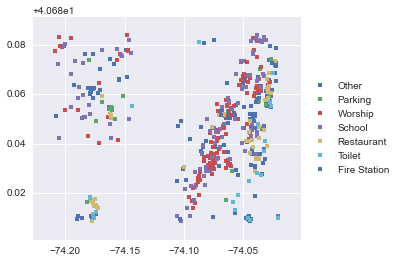

In [27]:
#########################################################
# Create Scatter Plot of Grouped Amenities
#

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

def assign_amenityID(str):
    if (str == 'parking') or (str == 'parking_space'):
        return 1
    elif (str == 'place_of_worship'):
        return 2
    elif (str == 'school'):
        return 3
    elif (str == 'restaurant') or (str == '	fast_food'):
        return 4
    elif (str == 'toilets'):
        return 5    
    elif (str == 'fire_station'):
        return 6
    else:
        return 0

label = {0 : 'Other', 1:'Parking', 2:'Worship', 3:'School', 4:'Restaurant', 5:'Toilet', 6:'Fire Station'}

result =  coll.aggregate([ {'$match' : {'pos' : {'$ne' : None}, 'amenity' : {'$ne' : None}}},
                        {'$project' : {'amenity' : '$amenity', 'pos' : '$pos', 'name' : '$name'}},
                        ])
df1 = pd.DataFrame(list(result)).set_index('_id')

df1['lat'] = df1['pos'].apply(lambda row: row[0]) # extract Lat and Lon from POS array
df1['lon'] = df1['pos'].apply(lambda row: row[1]) # extract Lat and Lon from POS array
df1['amenityID'] = df1['amenity'].apply(assign_amenityID)

groups = df1.groupby('amenityID')
fig = plt.figure()
ax = plt.subplot(111)
ax.margins(0.10) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.lon, group.lat, marker='.', linestyle='', ms=9, label=label[name])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



<function matplotlib.pyplot.show>

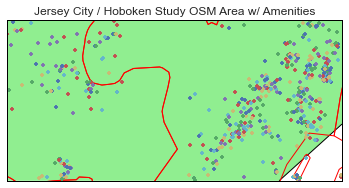

In [28]:
##################################################
# Create a Basemap plot
#
from mpl_toolkits.basemap import Basemap

m = Basemap(projection = 'mill',llcrnrlat = 40.6881, urcrnrlat = 40.7646,
            llcrnrlon = -74.2086, urcrnrlon = -74.0201, resolution = 'c')
# To get the basemap plot in the summary, change the resolutuin to 'f'
#
m.drawcoastlines(linewidth = 1)
m.drawcounties(color = 'r',linewidth = 1.0)
m.drawrivers(color = 'b')
m.fillcontinents(color='lightgreen', lake_color='#FFFFFF')
m.drawmapboundary(fill_color='#FFFFFF')

lats = df1['lat'].tolist()
lons = df1['lon'].tolist()
vals = df1['amenityID'].tolist()

for lon, lat, val in zip(lons, lats, vals):
    x,y = m(lon, lat)
    m.plot(x, y, '.', markersize = 8, alpha = 1)

plt.title('Jersey City / Hoboken Study OSM Area w/ Amenities')
plt.show